# Isomap examples

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
project_root

'/Users/airdac/Documents/Uni/Second/TFM/TFM_Adria/code'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import pyreadr
import pickle
from scipy.stats import pearsonr, gaussian_kde

from d_and_c import divide_conquer
from d_and_c.private_d_and_c import perform_procrustes
from d_and_c.methods import DRMethod, isomap
from d_and_c.utils import benchmark, runif_in_tetrahedron
from scipy.spatial.distance import pdist, squareform

np.random.seed(42)
pickle_path = os.path.join(os.getcwd(), "pickles")
os.makedirs(pickle_path, exist_ok=True)

## 1. Tetrahedron

In [ ]:
# Load all_data.RData
rdata = pyreadr.read_r(os.path.join(project_root, 'd_and_c', 'MNIST.RData'))

all_data_pixels = rdata["all_data_pixels"]
target = rdata["target"]
type_data = rdata["type_data"]

target = np.squeeze(np.array(target))
type_data = np.squeeze(np.array(type_data))

# Select train images of numbers
numeric_target = pd.to_numeric(target, errors="coerce")
train_idx = (type_data == "train") & (pd.notnull(numeric_target))

MNIST_pixels = all_data_pixels.loc[train_idx].values
MNIST_target = numeric_target[train_idx]

print(f"MNIST_pixels shape: {MNIST_pixels.shape}")
print(f"MNIST_target shape: {MNIST_target.shape}")

MNIST_pixels shape: (345035, 784)
MNIST_target shape: (345035,)


In [ ]:
# Split data into two equally sized partitions
n_images = MNIST_target.shape[0]
shuffled_indices = np.random.permutation(n_images)
partitions_idx = np.array_split(shuffled_indices, 2)

MNIST_pixels1 = MNIST_pixels[partitions_idx[0], :]
MNIST_target1 = MNIST_target[partitions_idx[0]]

MNIST_pixels2 = MNIST_pixels[partitions_idx[1], :]
MNIST_target2 = MNIST_target[partitions_idx[1]]

print(
    f"Partition 1 pixels shape: {MNIST_pixels1.shape}, targets shape: {MNIST_target1.shape}")
print(
    f"Partition 2 pixels shape: {MNIST_pixels2.shape}, targets shape: {MNIST_target2.shape}")

Partition 1 pixels shape: (172518, 784), targets shape: (172518,)
Partition 2 pixels shape: (172517, 784), targets shape: (172517,)


In [ ]:
MNIST_bare1, time_MNIST_bare1 = benchmark(mds_smacof,
                                          MNIST_pixels1, r=2, verbose=2)

### 1.1 Tetrahedron vertices

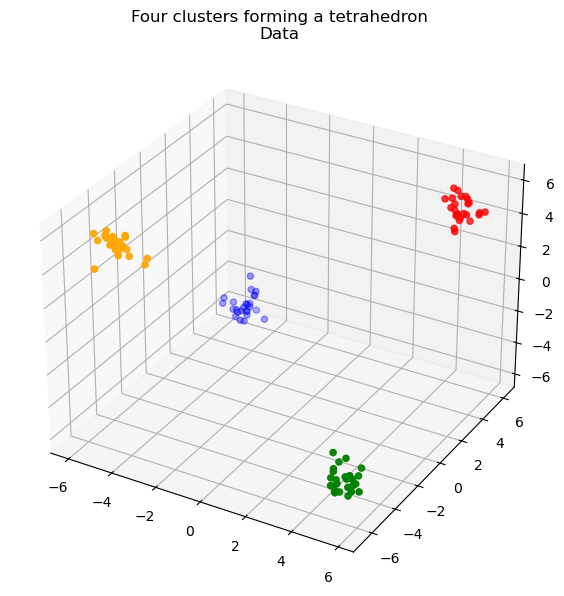

In [3]:
## Generate data
n_points = 100
points_per_cluster = n_points // 4

# Define vertices of a tetrahedron
vertices = np.array([
    [1, 1, 1],
    [1, -1, -1],
    [-1, 1, -1],
    [-1, -1, 1]
]) * 5


# Generate clusters with gaussian noise around each vertex
clusters = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters.append(cluster)
tetrahedron = np.vstack(clusters)

colors = ['red', 'green', 'blue', 'orange']
cluster_colors = np.repeat(colors, points_per_cluster)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tetrahedron[:,0], tetrahedron[:,1], tetrahedron[:,2],
            color=cluster_colors)
ax.set_title('Four clusters forming a tetrahedron\nData')
plt.show()

In [4]:
distances = squareform(pdist(vertices)); distances

array([[ 0.        , 14.14213562, 14.14213562, 14.14213562],
       [14.14213562,  0.        , 14.14213562, 14.14213562],
       [14.14213562, 14.14213562,  0.        , 14.14213562],
       [14.14213562, 14.14213562, 14.14213562,  0.        ]])

In [ ]:
# Apply Isomap
%time tetrahedron_embedding_1 = isomap(tetrahedron, r=2, n_neighbors=3)
%time tetrahedron_embedding_2 = isomap(tetrahedron, r=2, n_neighbors=5)
%time tetrahedron_embedding_3 = isomap(tetrahedron, r=2, n_neighbors=7)
%time tetrahedron_embedding_4 = isomap(tetrahedron, r=2, n_neighbors=9)

CPU times: user 31.2 ms, sys: 5.89 ms, total: 37.1 ms
Wall time: 16.2 ms
CPU times: user 67.3 ms, sys: 31.5 ms, total: 98.8 ms
Wall time: 26.1 ms
CPU times: user 58.2 ms, sys: 9.18 ms, total: 67.4 ms
Wall time: 9.07 ms
CPU times: user 31.3 ms, sys: 166 μs, total: 31.5 ms
Wall time: 5.12 ms


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/pyth

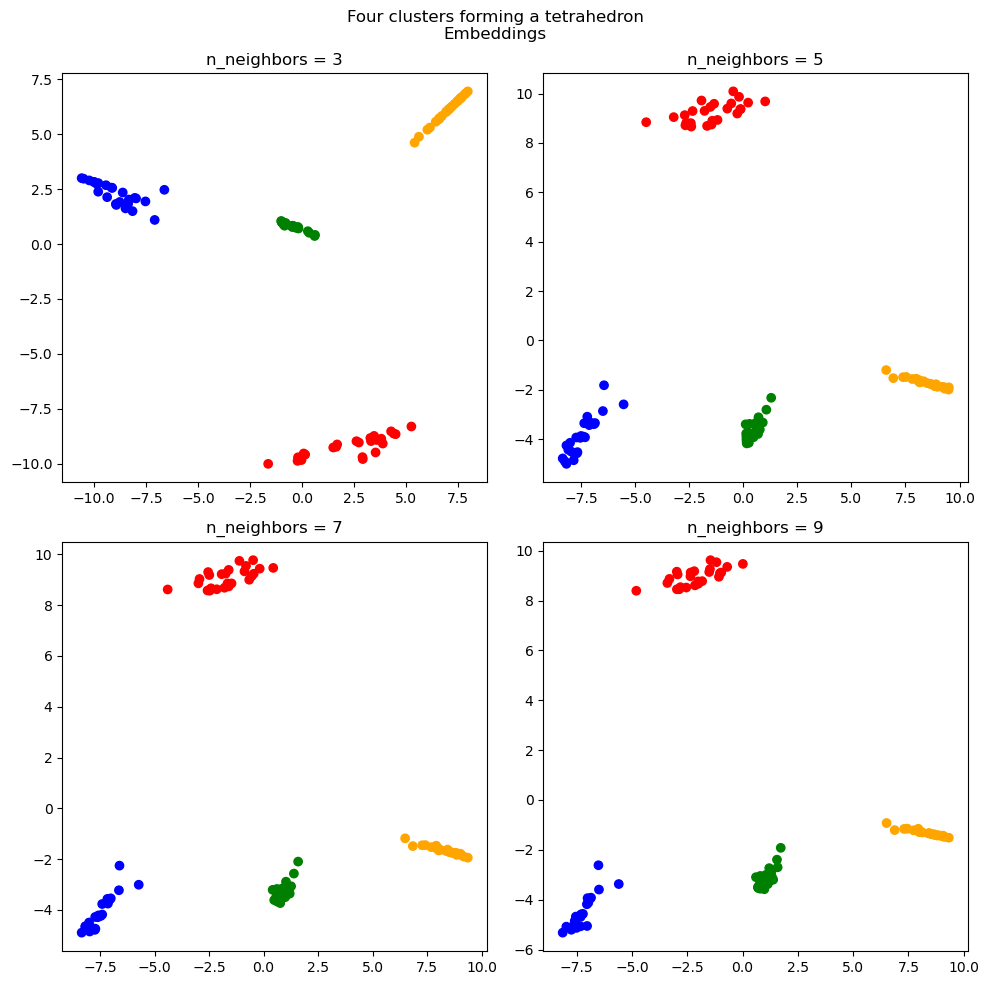

In [ ]:
# Plot the Isomap embeddings
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nEmbeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron_embedding_1[:, 0], tetrahedron_embedding_1[:, 1],
            c=cluster_colors)
ax1.set_title('n_neighbors = 3')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron_embedding_2[:, 0], tetrahedron_embedding_2[:, 1],
            c=cluster_colors)
ax2.set_title('n_neighbors = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron_embedding_3[:, 0], tetrahedron_embedding_3[:, 1],
            c=cluster_colors)
ax3.set_title('n_neighbors = 7')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron_embedding_4[:, 0], tetrahedron_embedding_4[:, 1],
            c=cluster_colors)
ax4.set_title('n_neighbors = 9')

fig.tight_layout()

It looks like slight changes in the dataset can vary the vertices order. Let us generate more datasets and see if opposite vertices can become adjacent.

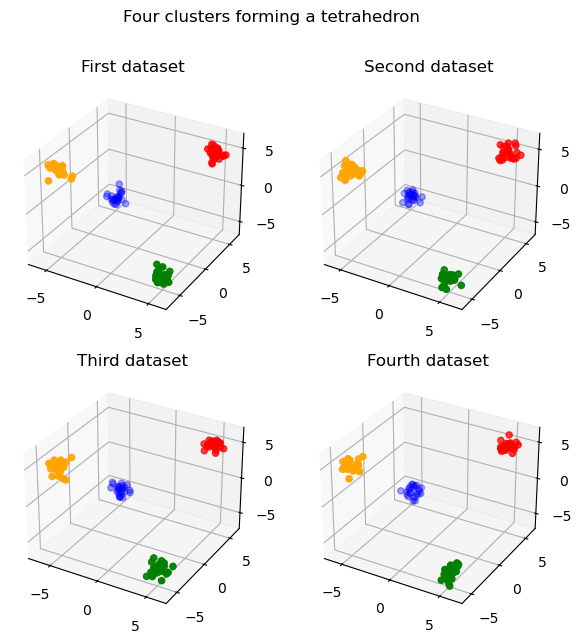

In [10]:
# Generate new datasets
clusters2 = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters2.append(cluster)
tetrahedron2 = np.vstack(clusters2)

clusters3 = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters3.append(cluster)
tetrahedron3 = np.vstack(clusters3)

clusters4 = []
for vertex in vertices:
    cluster = np.random.randn(points_per_cluster, 3) * 0.5 + vertex
    clusters4.append(cluster)
tetrahedron4 = np.vstack(clusters4)

fig = plt.figure(figsize=(7, 7))
fig.suptitle('Four clusters forming a tetrahedron')

ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(tetrahedron[:, 0], tetrahedron[:, 1], tetrahedron[:, 2],
           color=cluster_colors)
ax1.set_title('First dataset')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(tetrahedron2[:, 0], tetrahedron2[:, 1], tetrahedron2[:, 2],
            color=cluster_colors)
ax2.set_title('Second dataset')

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(tetrahedron3[:, 0], tetrahedron3[:, 1], tetrahedron3[:, 2],
            color=cluster_colors)
ax3.set_title('Third dataset')

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(tetrahedron4[:, 0], tetrahedron4[:, 1], tetrahedron4[:, 2],
            color=cluster_colors)
ax4.set_title('Fourth dataset')
plt.show()

In [14]:
# Apply Isomap to different datasets
%time tetrahedron1_embedding = isomap(tetrahedron, r=2, n_neighbors=7)
%time tetrahedron2_embedding = isomap(tetrahedron2, r=2, n_neighbors=7)
%time tetrahedron3_embedding = isomap(tetrahedron3, r=2, n_neighbors=7)
%time tetrahedron4_embedding = isomap(tetrahedron4, r=2, n_neighbors=7)

CPU times: user 26.8 ms, sys: 9.37 ms, total: 36.2 ms
Wall time: 15.9 ms
CPU times: user 28.6 ms, sys: 36.5 ms, total: 65.1 ms
Wall time: 10 ms
CPU times: user 47.7 ms, sys: 1.2 ms, total: 48.9 ms
Wall time: 8.21 ms
CPU times: user 45.1 ms, sys: 118 μs, total: 45.2 ms
Wall time: 5.01 ms


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/pyth

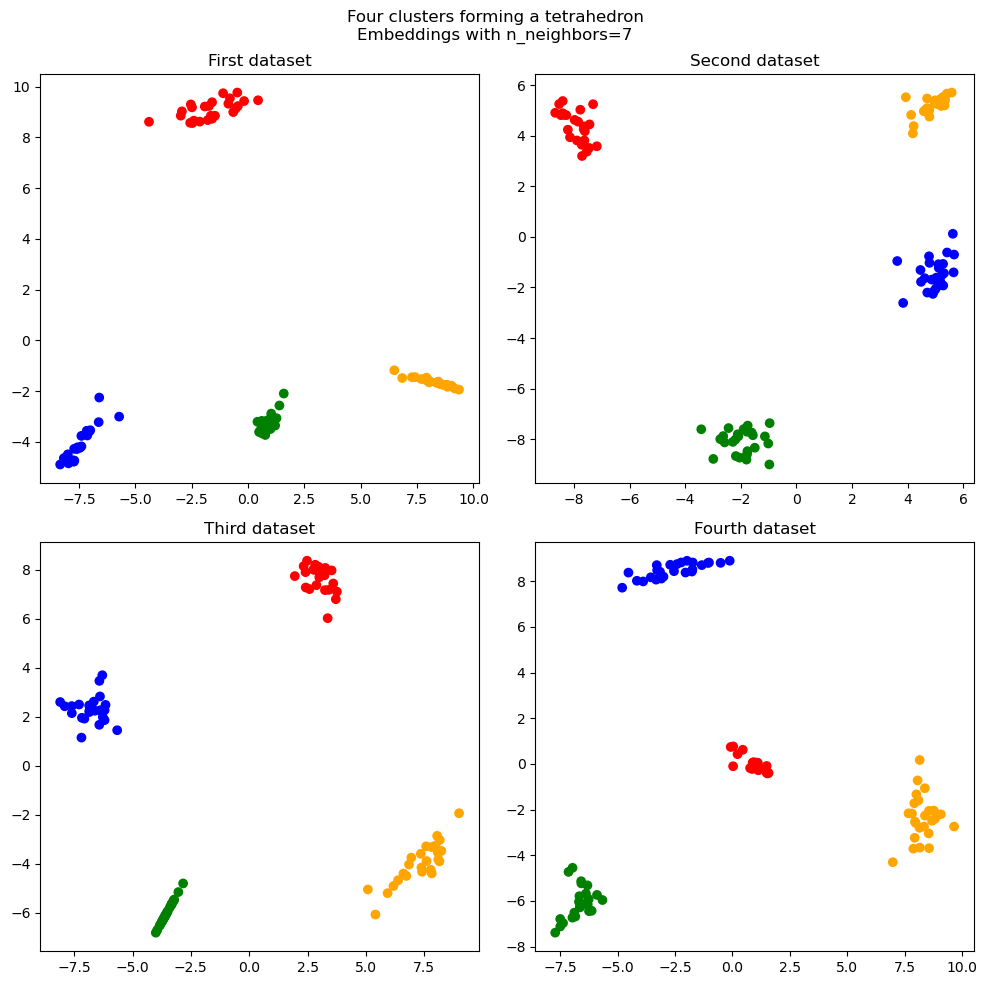

In [15]:
# Plot the Isomap embeddings of the four datasets
fig = plt.figure(figsize=(10, 10))
fig.suptitle(
    'Four clusters forming a tetrahedron\nEmbeddings with n_neighbors=7')

ax1 = fig.add_subplot(221)
ax1.scatter(tetrahedron1_embedding[:, 0], tetrahedron1_embedding[:, 1],
            c=cluster_colors)
ax1.set_title('First dataset')

ax2 = fig.add_subplot(222)
ax2.scatter(tetrahedron2_embedding[:, 0], tetrahedron2_embedding[:, 1],
            c=cluster_colors)
ax2.set_title('Second dataset')

ax3 = fig.add_subplot(223)
ax3.scatter(tetrahedron3_embedding[:, 0], tetrahedron3_embedding[:, 1],
            c=cluster_colors)
ax3.set_title('Third dataset')

ax4 = fig.add_subplot(224)
ax4.scatter(tetrahedron4_embedding[:, 0], tetrahedron4_embedding[:, 1],
            c=cluster_colors)
ax4.set_title('Fourth dataset')

fig.tight_layout()

Note that clusters are disconnected in the kNN graph, so they have been connected with the shortest edges in order to compute geodesic paths between vertices.
Indeed, we can conclude that slight changes in the dataset can producde significant changes in the embedding. In this case, variations in the noise of each vertex of the tetrahedron may embed a pair of vertices in the high-dimensional space into opposite or adjacent vertices of a square (or even not form a square). This happens both with t-SNE and Isomap.

### 3.1 Solid tetrahedron

In [4]:
# Define vertices of a regular tetrahedron with v1 at the origin
vertices = np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0.5, np.sqrt(3)/2, 0],
                     [0.5, np.sqrt(3)/6, np.sqrt(6)/3]
                     ])

# Check the tetrahedron in regular
dist_matrix = squareform(pdist(vertices))
print("Distance matrix between vertices:\n", dist_matrix)

Distance matrix between vertices:
 [[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [5]:
# Sample points uniformly at random inside the tetrahedron
solid_tetrahedron = runif_in_tetrahedron(1000, vertices)

In [6]:
# Compute the closest vertex for each point in sims
def get_point_colors(solid_tetrahedron):
    # Use NumPy broadcasting to compute distance between the i-th point and the j-th vertex
    distances = np.linalg.norm(
        solid_tetrahedron[:, None, :] - vertices[None, :, :], axis=2)
    closest_vertex = np.argmin(distances, axis=1)

    # Define a color map
    colors_map = np.array(['red', 'green', 'blue', 'orange'])
    point_colors = colors_map[closest_vertex]
    return point_colors
point_colors = get_point_colors(solid_tetrahedron)

In [7]:
# Plot Data in Tetrahedron Mesh
# i, j, k are the indices of the tetrahedron vertices that make up the x, y, z coordinates of the faces' vertices
fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=[0, 0, 0, 1],
        j=[1, 1, 2, 2],
        k=[2, 3, 3, 3],
        color='grey',
        opacity=0.2,
        name='Tetrahedron'
    ),
    go.Scatter3d(
        x=solid_tetrahedron[:, 0],
        y=solid_tetrahedron[:, 1],
        z=solid_tetrahedron[:, 2],
        mode='markers',
        marker=dict(size=3, color=point_colors),
        name='Random Points'
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ),
    title="Solid regular tetrahedron: Data"
)

fig.show()

In [13]:
# Find the best value of n_neighbors for a solid tetrahedron
%time solid_embedding_n_neighbors3 = isomap(solid_tetrahedron4, r=2, n_neighbors = 3)
%time solid_embedding_n_neighbors5 = isomap(solid_tetrahedron, r=2, n_neighbors = 5)
%time solid_embedding_n_neighbors7 = isomap(solid_tetrahedron2, r=2, n_neighbors = 7)
%time solid_embedding_n_neighbors9 = isomap(solid_tetrahedron3, r=2, n_neighbors = 9)

CPU times: user 156 ms, sys: 4.95 ms, total: 161 ms
Wall time: 155 ms
CPU times: user 1.33 s, sys: 584 ms, total: 1.92 s
Wall time: 256 ms
CPU times: user 742 ms, sys: 1.34 s, total: 2.08 s
Wall time: 277 ms
CPU times: user 1 s, sys: 1.13 s, total: 2.13 s
Wall time: 293 ms


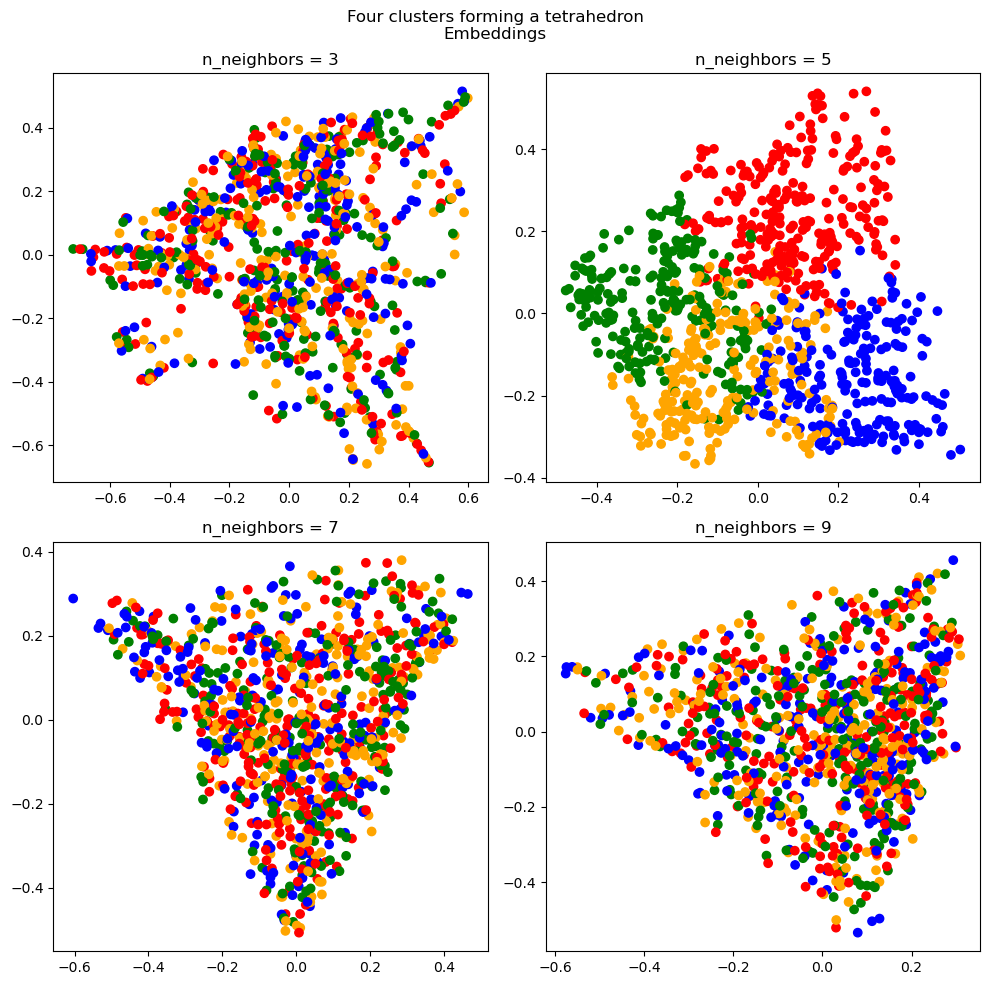

In [14]:
# Plot the Isomap embeddings
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nEmbeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(solid_embedding_n_neighbors3[:, 0], solid_embedding_n_neighbors3[:, 1],
            c=point_colors)
ax1.set_title('n_neighbors = 3')

ax2 = fig.add_subplot(222)
ax2.scatter(solid_embedding_n_neighbors5[:, 0], solid_embedding_n_neighbors5[:, 1],
            c=point_colors)
ax2.set_title('n_neighbors = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(solid_embedding_n_neighbors7[:, 0], solid_embedding_n_neighbors7[:, 1],
            c=point_colors)
ax3.set_title('n_neighbors = 7')

ax4 = fig.add_subplot(224)
ax4.scatter(solid_embedding_n_neighbors9[:, 0], solid_embedding_n_neighbors9[:, 1],
            c=point_colors)
ax4.set_title('n_neighbors = 9')

fig.tight_layout()

Let us try two more n_neighbors values.

In [15]:
# Test n_neighbors = 4, 6
%time solid_embedding_n_neighbors4 = isomap(solid_tetrahedron4, r=2, n_neighbors = 4)
%time solid_embedding_n_neighbors6 = isomap(solid_tetrahedron, r=2, n_neighbors = 6)

CPU times: user 208 ms, sys: 6.89 ms, total: 215 ms
Wall time: 206 ms
CPU times: user 1.29 s, sys: 722 ms, total: 2.01 s
Wall time: 273 ms


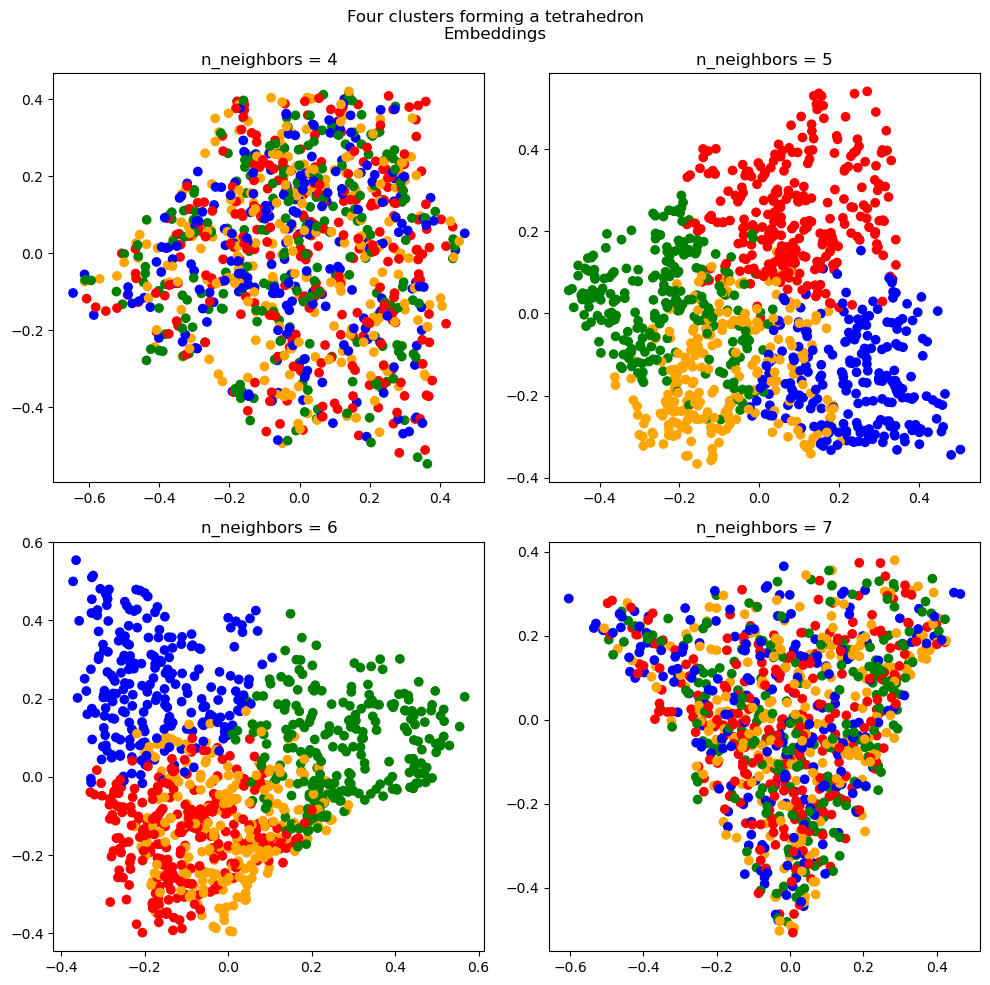

In [17]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Four clusters forming a tetrahedron\nEmbeddings')

ax1 = fig.add_subplot(221)
ax1.scatter(solid_embedding_n_neighbors4[:, 0], solid_embedding_n_neighbors4[:, 1],
            c=point_colors)
ax1.set_title('n_neighbors = 4')

ax2 = fig.add_subplot(222)
ax2.scatter(solid_embedding_n_neighbors5[:, 0], solid_embedding_n_neighbors5[:, 1],
            c=point_colors)
ax2.set_title('n_neighbors = 5')

ax3 = fig.add_subplot(223)
ax3.scatter(solid_embedding_n_neighbors6[:, 0], solid_embedding_n_neighbors6[:, 1],
            c=point_colors)
ax3.set_title('n_neighbors = 6')

ax4 = fig.add_subplot(224)
ax4.scatter(solid_embedding_n_neighbors7[:, 0], solid_embedding_n_neighbors7[:, 1],
            c=point_colors)
ax4.set_title('n_neighbors = 7')

fig.tight_layout()

On the first solid tetrahedorn, the best embedding is obtained when n_neighbors = 5.

In [ ]:
# Generate four solid tetrahedrons and compare its Isomap embeddings
solid_tetrahedron2 = runif_in_tetrahedron(1000, vertices)
solid_tetrahedron3 = runif_in_tetrahedron(1000, vertices)
solid_tetrahedron4 = runif_in_tetrahedron(1000, vertices)

In [9]:
# Compute closest vertex
point_colors2 = get_point_colors(solid_tetrahedron2)
point_colors3 = get_point_colors(solid_tetrahedron3)
point_colors4 = get_point_colors(solid_tetrahedron4)

In [18]:
# Apply Isomap
%time solid_tetrahedron_embedding1 = isomap(solid_tetrahedron, r=2, n_neighbors=5)
%time solid_tetrahedron_embedding2 = isomap(solid_tetrahedron2, r=2, n_neighbors=5)
%time solid_tetrahedron_embedding3 = isomap(solid_tetrahedron3, r=2, n_neighbors=5)
%time solid_tetrahedron_embedding4 = isomap(solid_tetrahedron4, r=2, n_neighbors=5)

CPU times: user 197 ms, sys: 5.31 ms, total: 202 ms
Wall time: 190 ms
CPU times: user 1.4 s, sys: 480 ms, total: 1.88 s
Wall time: 252 ms
CPU times: user 995 ms, sys: 950 ms, total: 1.95 s
Wall time: 254 ms
CPU times: user 1.05 s, sys: 867 ms, total: 1.91 s
Wall time: 247 ms


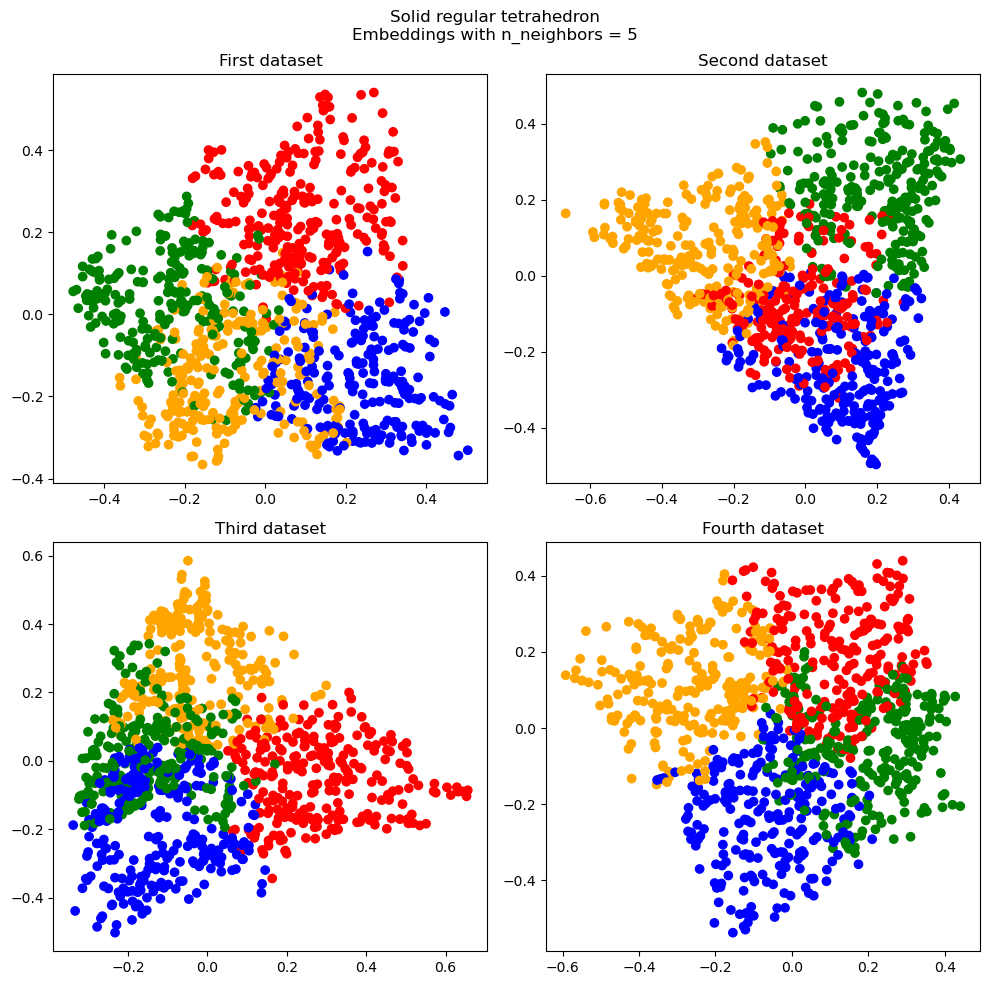

In [19]:
# Plot solid tetrahedron embeddings
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Solid regular tetrahedron\nEmbeddings with n_neighbors = 5')

ax1 = fig.add_subplot(221)
ax1.scatter(solid_tetrahedron_embedding1[:, 0], solid_tetrahedron_embedding1[:, 1],
            c=point_colors)
ax1.set_title('First dataset')

ax2 = fig.add_subplot(222)
ax2.scatter(solid_tetrahedron_embedding2[:, 0], solid_tetrahedron_embedding2[:, 1],
            c=point_colors2)
ax2.set_title('Second dataset')

ax3 = fig.add_subplot(223)
ax3.scatter(solid_tetrahedron_embedding3[:, 0], solid_tetrahedron_embedding3[:, 1],
            c=point_colors3)
ax3.set_title('Third dataset')

ax4 = fig.add_subplot(224)
ax4.scatter(solid_tetrahedron_embedding4[:, 0], solid_tetrahedron_embedding4[:, 1],
            c=point_colors4)
ax4.set_title('Fourth dataset')
fig.tight_layout()

Again, results are similar to those observed in t-SNE. That is, oposite vertices are not consistent with respect to changes in the noise of the dataset. Moreover, in a solid tetrahedron, the kNN graph is connected, so the algorithm has not been modified as in the previous experiment with data around the tetrahedron' vertices.

## 2. MNIST

## 2.1 Until the 24th of April

In [6]:
# Load all_data.RData
rdata = pyreadr.read_r(os.path.join(project_root, 'd_and_c', 'MNIST.RData'))

all_data_pixels = rdata["all_data_pixels"]
target = rdata["target"]
type_data = rdata["type_data"]

target = np.squeeze(np.array(target))
type_data = np.squeeze(np.array(type_data))

# Select train images of numbers
numeric_target = pd.to_numeric(target, errors="coerce")
train_idx = (type_data == "train") & (pd.notnull(numeric_target))

MNIST_pixels = all_data_pixels.loc[train_idx].values
MNIST_target = numeric_target[train_idx]

print(f"MNIST_pixels shape: {MNIST_pixels.shape}")
print(f"MNIST_target shape: {MNIST_target.shape}")

MNIST_pixels shape: (345035, 784)
MNIST_target shape: (345035,)


In [4]:
# Split data into two equally sized partitions
n_images = MNIST_target.shape[0]
shuffled_indices = np.random.permutation(n_images)
partitions_idx = np.array_split(shuffled_indices, 2)

MNIST_pixels1 = MNIST_pixels[partitions_idx[0], :]
MNIST_target1 = MNIST_target[partitions_idx[0]]

MNIST_pixels2 = MNIST_pixels[partitions_idx[1], :]
MNIST_target2 = MNIST_target[partitions_idx[1]]

print(
    f"Partition 1 pixels shape: {MNIST_pixels1.shape}, targets shape: {MNIST_target1.shape}")
print(
    f"Partition 2 pixels shape: {MNIST_pixels2.shape}, targets shape: {MNIST_target2.shape}")

Partition 1 pixels shape: (172518, 784), targets shape: (172518,)
Partition 2 pixels shape: (172517, 784), targets shape: (172517,)


Read pickled 5000-rows-subset instead of computing it again.

In [4]:
with open(os.path.join(project_root, 'd_and_c', 'MNIST_5000.pkl'), "rb") as f:
    bare_data = pickle.load(f)
    sampled_pixels1 = bare_data["pixels"]
    sampled_target1 = bare_data["target"]

In [5]:
MNIST_bare1, time_MNIST_bare1 = benchmark(isomap,
                                          sampled_pixels1, r=2, verbose=2)
# Save experiment results
with open(os.path.join(pickle_path, "MNIST_5000_Isomap.pkl"), "wb") as f:
    pickle.dump({"embedding": MNIST_bare1, "runtime": time_MNIST_bare1},
                f)

In [6]:
l, c_points = 1000, 100
MNIST_dc1, time_MNIST_dc1 = benchmark(divide_conquer,
                                      DRMethod.Isomap, sampled_pixels1, l=l, c_points=c_points, r=2, verbose=2)
# Save experiment results
with open(os.path.join(pickle_path, "MNIST_5000_DC_Isomap.pkl"), "wb") as f:
    pickle.dump({"embedding": MNIST_dc1, "runtime": time_MNIST_dc1},
                f)

Projecting partition 1...
Projecting partition 2...
Projecting partition 3...
Projecting partition 4...
Projecting partition 5...
Projecting partition 6...


In [4]:
n, l, c_points = 5000, 1000, 100

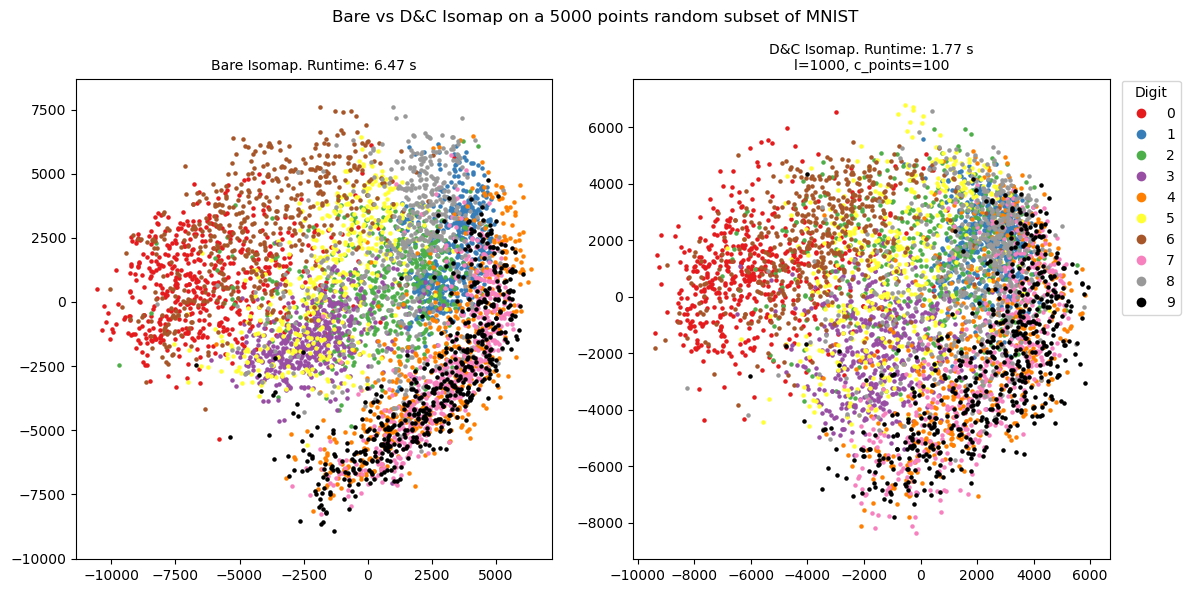

In [7]:
# Plot the embedding
with open(os.path.join(project_root, 'd_and_c', 'MNIST_5000.pkl'), "rb") as f:
    bare_data = pickle.load(f)
    sampled_pixels1 = bare_data["pixels"]
    sampled_target1 = bare_data["target"]

with open(os.path.join(pickle_path, "MNIST_5000_Isomap.pkl"), "rb") as f:
    bare_data = pickle.load(f)
    MNIST_bare1 = bare_data["embedding"]
    time_MNIST_bare1 = bare_data["runtime"]

with open(os.path.join(pickle_path, "MNIST_5000_DC_Isomap.pkl"), "rb") as f:
    dc_data = pickle.load(f)
    MNIST_dc1 = dc_data["embedding"]
    time_MNIST_dc1 = dc_data["runtime"]

MNIST_dc1[:,1] = - MNIST_dc1[:,1]

digits = np.unique(sampled_target1)

set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black as RGB tuple
cmap = mcolors.ListedColormap(set1_colors[:len(digits)])

# Create custom legend handles with larger markers
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                  for i, digit in enumerate(digits)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Partition 1
for i, digit in enumerate(digits):
    mask = sampled_target1 == digit
    ax1.scatter(MNIST_bare1[mask, 0], MNIST_bare1[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax1.set_title(f'Bare Isomap. Runtime: {time_MNIST_bare1:.2f} s', fontsize=10)
ax1.axis('equal')

# Partition 2
for i, digit in enumerate(digits):
    mask = sampled_target1 == digit
    ax2.scatter(MNIST_dc1[mask, 0], MNIST_dc1[mask, 1],
                color=cmap(i),
                s=5)
ax2.set_title(
    f'D&C Isomap. Runtime: {time_MNIST_dc1:.2f} s\nl={l}, c_points={c_points}', fontsize=10)
ax2.axis('equal')
ax2.legend(handles=legend_handles, title="Digit",
           bbox_to_anchor=(1.01, 1.01), loc='upper left')

fig.suptitle(f'Bare vs D&C Isomap on a 5000 points random subset of MNIST')
plt.tight_layout()
plt.show()

The embedding badly classifies digits both in bare and D&C Isomap. That being said, Isomap is significantly faster than SMACOF.

Let us plot each digit separately to understand them better.

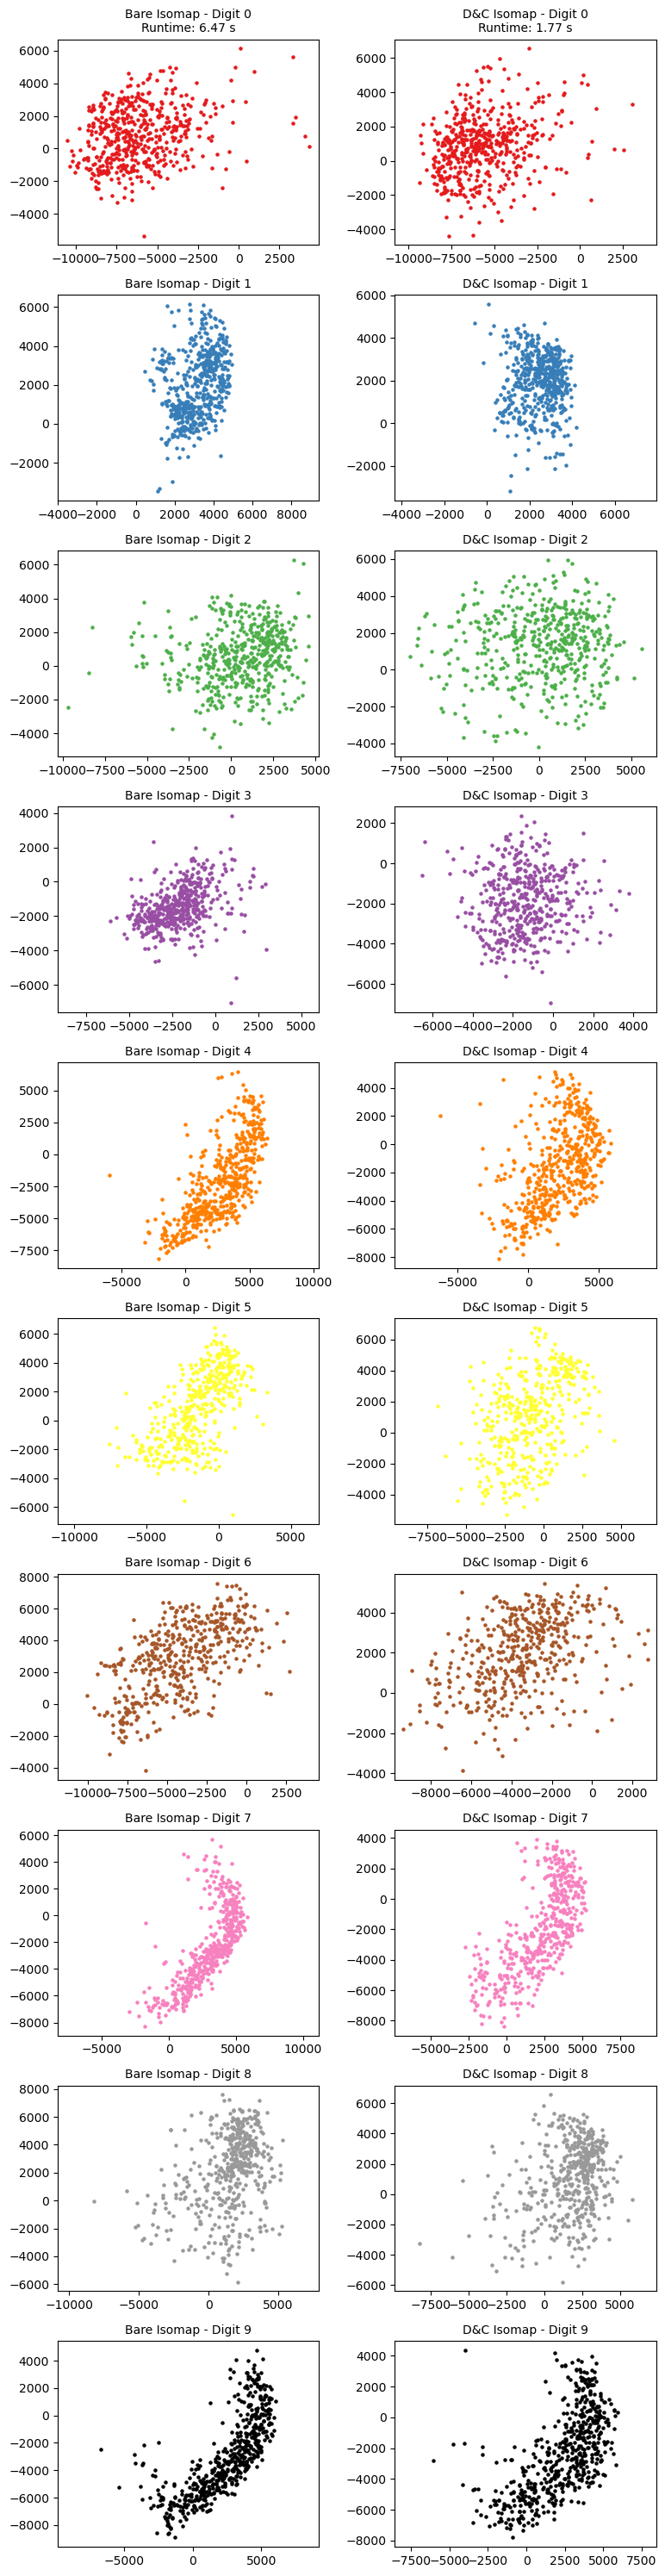

In [8]:
# Load embeddings
with open(os.path.join(pickle_path, "MNIST_5000_Isomap.pkl"), "rb") as f:
    bare_data = pickle.load(f)
    MNIST_bare1 = bare_data["embedding"]
    time_MNIST_bare1 = bare_data["runtime"]

with open(os.path.join(pickle_path, "MNIST_5000_DC_Isomap.pkl"), "rb") as f:
    dc_data = pickle.load(f)
    MNIST_dc1 = dc_data["embedding"]
    time_MNIST_dc1 = dc_data["runtime"]

MNIST_dc1[:, 1] = - MNIST_dc1[:, 1]

digits = np.unique(sampled_target1)

set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black as RGB tuple
cmap = mcolors.ListedColormap(set1_colors[:len(digits)])

# Create a 10x2 grid: one row per digit, columns for Bare and D&C
fig, axes = plt.subplots(len(digits), 2, figsize=(8, 30))
method_data = [
    ("Bare Isomap", MNIST_bare1, time_MNIST_bare1),
    ("D&C Isomap", MNIST_dc1, time_MNIST_dc1)
]

for row, digit in enumerate(digits):
    for col, (method_name, embedding, runtime) in enumerate(method_data):
        mask = sampled_target1 == digit
        ax = axes[row, col]
        ax.scatter(embedding[mask, 0], embedding[mask, 1],
                   color=cmap(row), s=5)
        if row == 0:
            ax.set_title(
                f"{method_name} - Digit {int(digit)}\nRuntime: {runtime:.2f} s", fontsize=10)
        else:
            ax.set_title(f"{method_name} - Digit {int(digit)}", fontsize=10)
        ax.axis('equal')
plt.tight_layout()
plt.show()

Next, we will apply a Procrustes transformation to digits 1-9 in order to align them with digit 0's embedding.

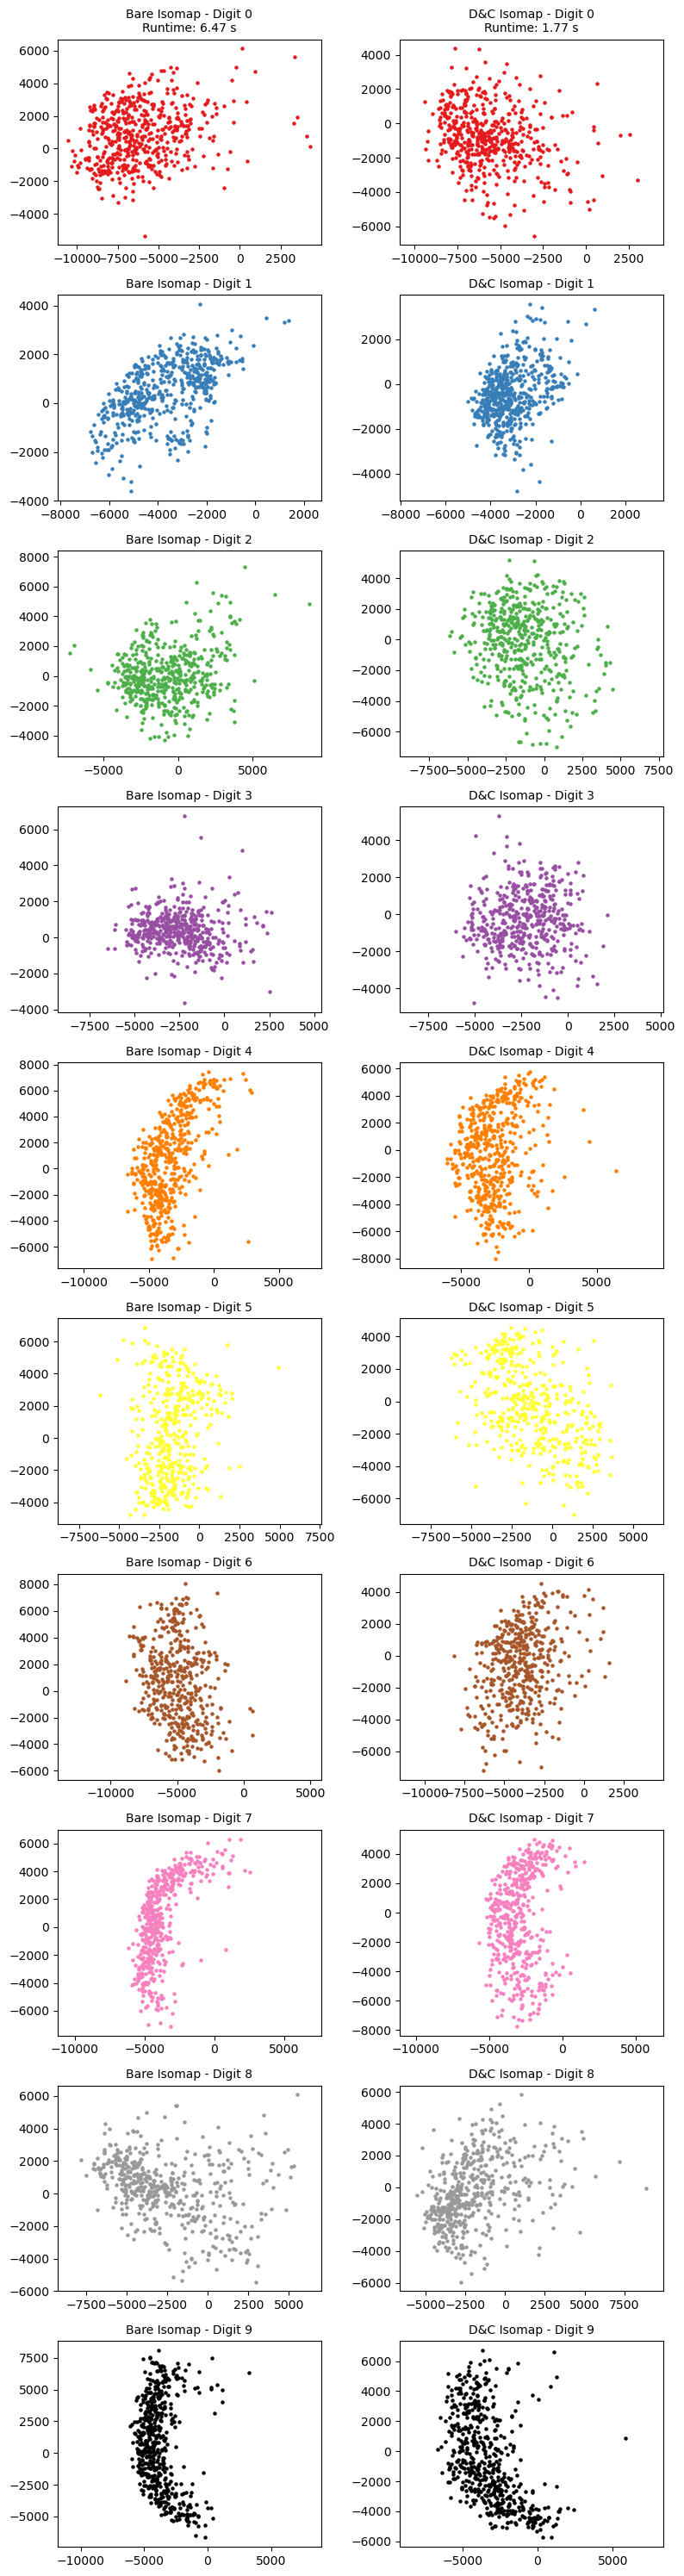

In [13]:
digits = np.unique(sampled_target1)

set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black as RGB tuple
cmap = mcolors.ListedColormap(set1_colors[:len(digits)])


# Obtain target matrix to apply Procrustes transformation
digit_0 = MNIST_bare1[sampled_target1 == 0]
n_rows_target = digit_0.shape[0]

n_rows_digits = [MNIST_bare1[sampled_target1==digit].shape[0] for digit in digits]
c_points = min(n_rows_digits)

sampled_idx = np.random.choice(n_rows_target, size=c_points, replace=False)
target = digit_0[sampled_idx, :]

# Create a 10x2 grid: one row per digit, columns for Bare and D&C
fig, axes = plt.subplots(len(digits), 2, figsize=(8, 30))
method_data = [
    ("Bare Isomap", MNIST_bare1, time_MNIST_bare1),
    ("D&C Isomap", MNIST_dc1, time_MNIST_dc1)
]

for col, (method_name, embedding, runtime) in enumerate(method_data):
    # Obtain target matrix to apply Procrustes transformation
    digit_0 = embedding[sampled_target1 == 0]
    n_rows_target = digit_0.shape[0]

    n_rows_digits = [embedding[sampled_target1==digit].shape[0] for digit in digits]
    c_points = min(n_rows_digits)

    sampled_idx = np.random.choice(n_rows_target, size=c_points, replace=False)
    target = digit_0[sampled_idx, :]

    # Plot digit embeddings
    for row, digit in enumerate(digits):
        x = embedding[sampled_target1 == digit]
        ax = axes[row, col]
        if row == 0:
            ax.scatter(x[:,0], x[:, 1],
                       color=cmap(row), s=5)
            ax.set_title(
                f"{method_name} - Digit {int(digit)}\nRuntime: {runtime:.2f} s", fontsize=10)
        else:
            # Align x to y using perform_procrustes
            x_aligned = perform_procrustes(x[:c_points,:], target, x)
            ax.scatter(x_aligned[:,0], x_aligned[:,1],
                   color=cmap(row), s=5)
            ax.set_title(f"{method_name} - Digit {int(digit)}", fontsize=10)
        ax.axis('equal')
plt.tight_layout()
plt.show()

Let us try to use different parameter values.

In [14]:
MNIST_Isomap_n_neighbors3, time_n_neighbors3 = benchmark(isomap,
                                                         sampled_pixels2,
                                                         n_neighbors=3)
MNIST_Isomap_n_neighbors5, time_n_neighbors5 = MNIST_bare2, time_MNIST_bare2
MNIST_Isomap_n_neighbors7, time_n_neighbors7 = benchmark(isomap,
                                                         sampled_pixels2,
                                                         n_neighbors=7)
MNIST_Isomap_n_neighbors9, time_n_neighbors9 = benchmark(isomap,
                                                         sampled_pixels2,
                                                         n_neighbors=9)

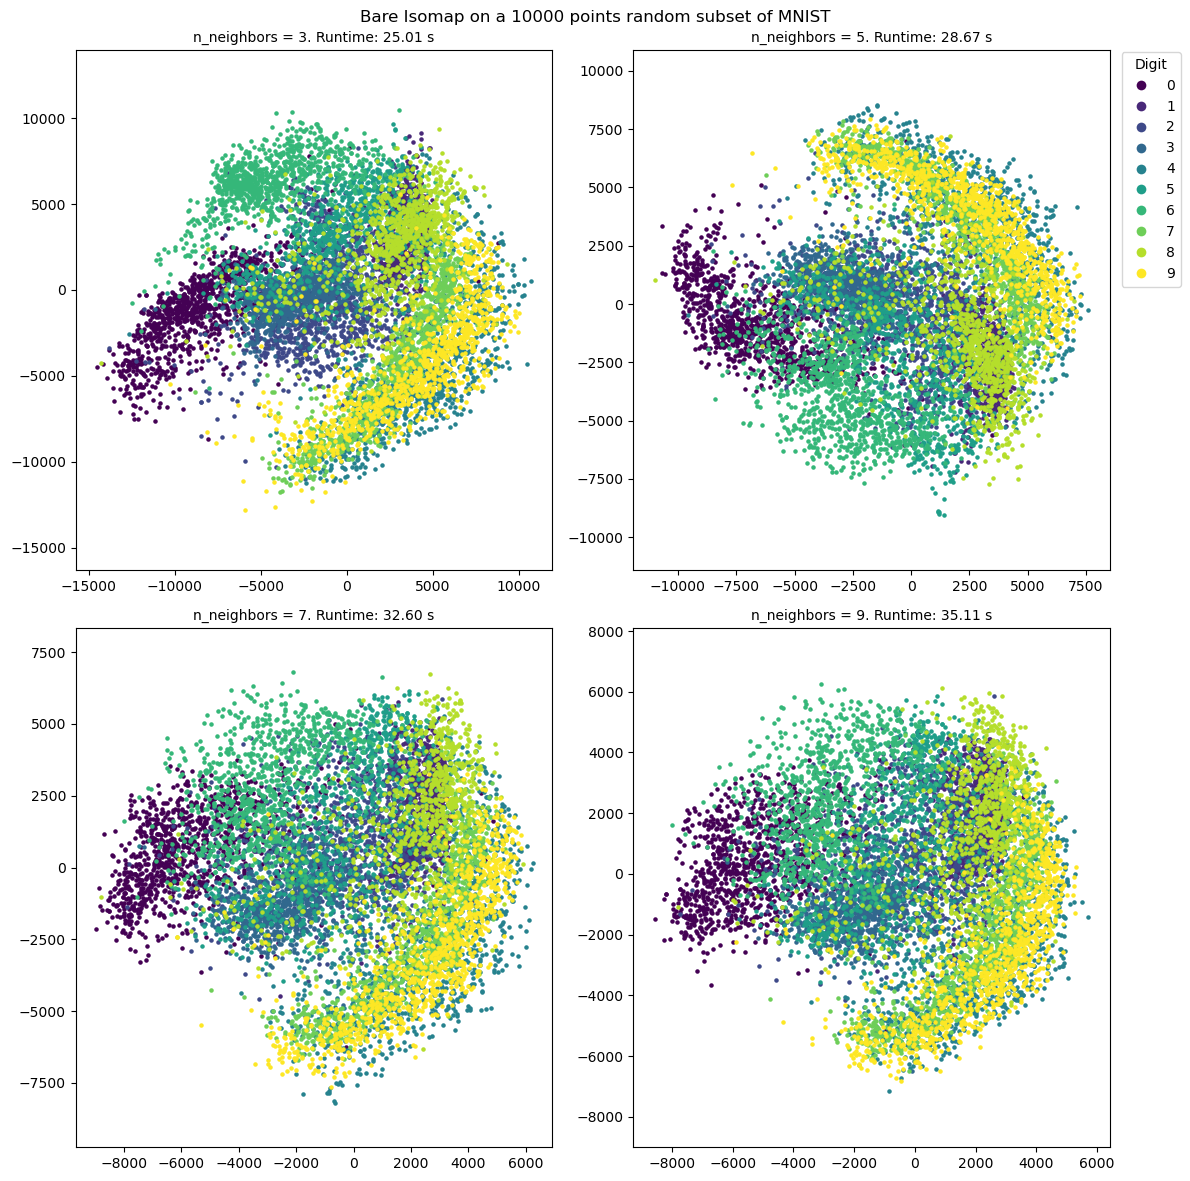

In [19]:
# Plot the embeddings
digits = np.unique(MNIST_target)
cmap = plt.get_cmap('viridis', len(digits))
# Create custom legend handles with larger markers
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                  for i, digit in enumerate(digits)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
# Partition 1
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax1.scatter(MNIST_Isomap_n_neighbors3[mask, 0], MNIST_Isomap_n_neighbors3[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax1.set_title(
    f'n_neighbors = 3. Runtime: {time_n_neighbors3:.2f} s', fontsize=10)
ax1.axis('equal')

# Partition 2
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax2.scatter(MNIST_Isomap_n_neighbors5[mask, 0], MNIST_Isomap_n_neighbors5[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax2.set_title(
    f'n_neighbors = 5. Runtime: {time_n_neighbors5:.2f} s', fontsize=10)
ax2.axis('equal')

# Partition 3
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax3.scatter(MNIST_Isomap_n_neighbors7[mask, 0], MNIST_Isomap_n_neighbors7[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax3.set_title(
    f'n_neighbors = 7. Runtime: {time_n_neighbors7:.2f} s', fontsize=10)
ax3.axis('equal')

# Partition 4
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax4.scatter(MNIST_Isomap_n_neighbors9[mask, 0], MNIST_Isomap_n_neighbors9[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax4.set_title(
    f'n_neighbors = 9. Runtime: {time_n_neighbors9:.2f} s', fontsize=10)
ax4.axis('equal')

ax2.legend(handles=legend_handles, title="Digit",
           bbox_to_anchor=(1.01, 1.01), loc='upper left')

fig.suptitle(f'Bare Isomap on a {n} points random subset of MNIST')
plt.tight_layout()
plt.show()

Let us try more parameter values.

In [20]:
MNIST_Isomap_n_neighbors11, time_n_neighbors11 = benchmark(isomap,
                                                         sampled_pixels2,
                                                         n_neighbors=11)
MNIST_Isomap_n_neighbors13, time_n_neighbors13 = benchmark(isomap,
                                                           sampled_pixels2,
                                                           n_neighbors=13)
MNIST_Isomap_n_neighbors15, time_n_neighbors15 = benchmark(isomap,
                                                         sampled_pixels2,
                                                         n_neighbors=15)
MNIST_Isomap_n_neighbors17, time_n_neighbors17 = benchmark(isomap,
                                                         sampled_pixels2,
                                                         n_neighbors=17)

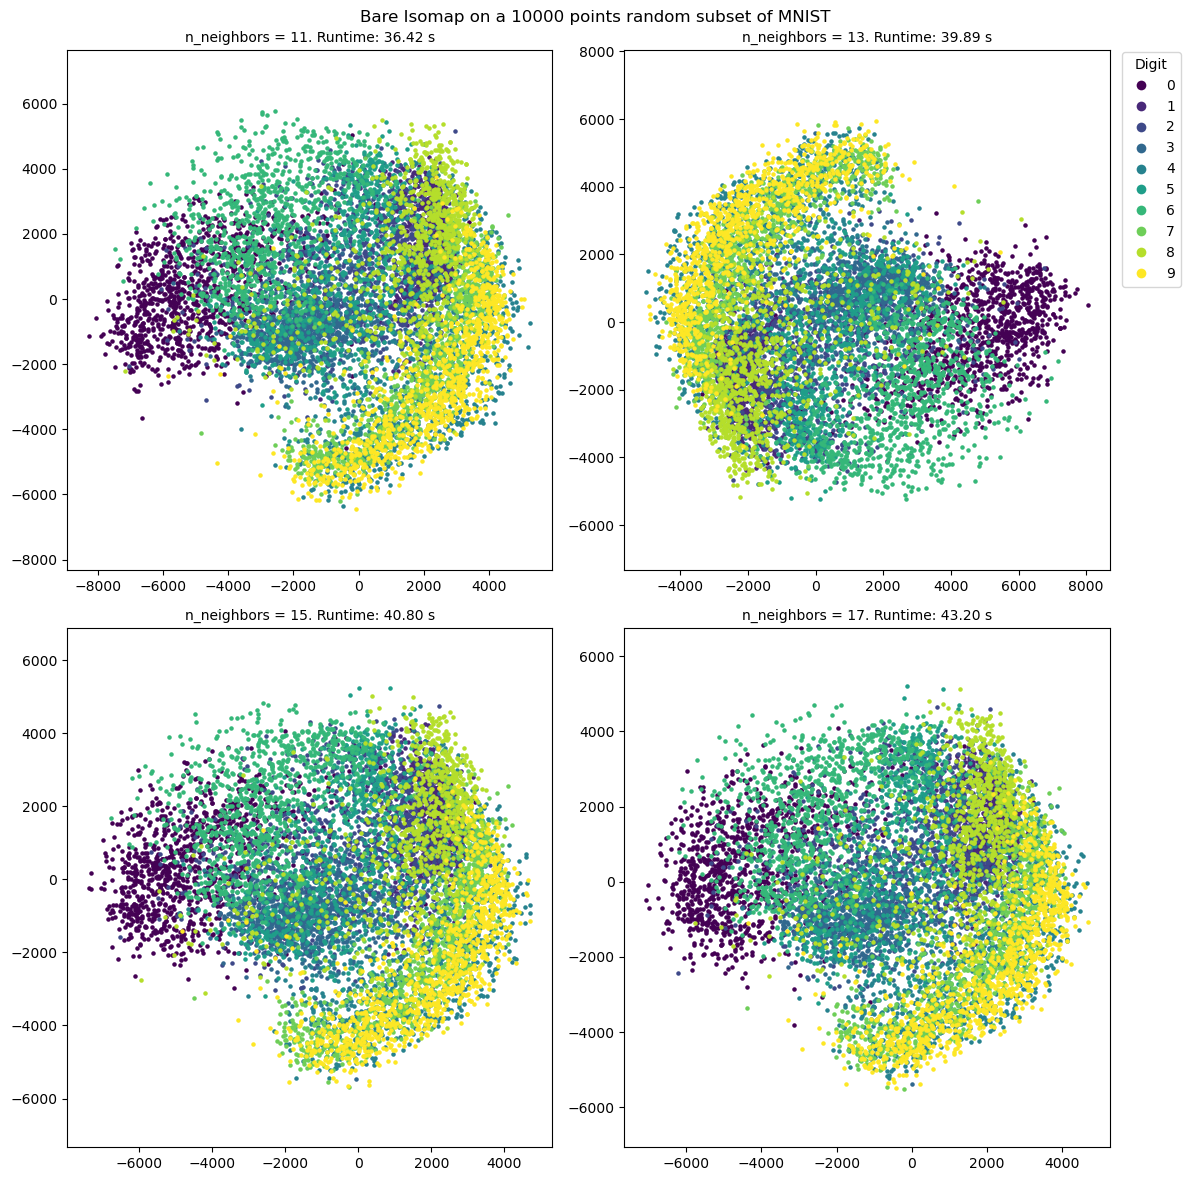

In [21]:
# Plot the embeddings
digits = np.unique(MNIST_target)
cmap = plt.get_cmap('viridis', len(digits))
# Create custom legend handles with larger markers
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                  for i, digit in enumerate(digits)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
# Partition 1
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax1.scatter(MNIST_Isomap_n_neighbors11[mask, 0], MNIST_Isomap_n_neighbors11[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax1.set_title(
    f'n_neighbors = 11. Runtime: {time_n_neighbors11:.2f} s', fontsize=10)
ax1.axis('equal')

# Partition 2
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax2.scatter(MNIST_Isomap_n_neighbors13[mask, 0], MNIST_Isomap_n_neighbors13[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax2.set_title(
    f'n_neighbors = 13. Runtime: {time_n_neighbors13:.2f} s', fontsize=10)
ax2.axis('equal')

# Partition 3
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax3.scatter(MNIST_Isomap_n_neighbors15[mask, 0], MNIST_Isomap_n_neighbors15[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax3.set_title(
    f'n_neighbors = 15. Runtime: {time_n_neighbors15:.2f} s', fontsize=10)
ax3.axis('equal')

# Partition 4
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax4.scatter(MNIST_Isomap_n_neighbors17[mask, 0], MNIST_Isomap_n_neighbors17[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax4.set_title(
    f'n_neighbors = 17. Runtime: {time_n_neighbors17:.2f} s', fontsize=10)
ax4.axis('equal')

ax2.legend(handles=legend_handles, title="Digit",
           bbox_to_anchor=(1.01, 1.01), loc='upper left')

fig.suptitle(f'Bare Isomap on a {n} points random subset of MNIST')
plt.tight_layout()
plt.show()

Even with different values of n_neighbors, Isomap keeps performing bad on the MNIST dataset.

Let us now try to apply Isomap to the whole partition 1.

In [ ]:
l, c_points = 1000, 100
MNIST_dc_full1, time_MNIST_dc_full1 = benchmark(divide_conquer,
                                                DRMethod.Isomap, MNIST_pixels1, l=l, c_points=c_points, r=2, verbose=2)

Projecting partition 1...
Projecting partition 2...
Projecting partition 3...
Projecting partition 4...
Projecting partition 5...
Projecting partition 6...
Projecting partition 7...
Projecting partition 8...
Projecting partition 9...
Projecting partition 10...
Projecting partition 11...
Projecting partition 12...
Projecting partition 13...
Projecting partition 14...
Projecting partition 15...
Projecting partition 16...
Projecting partition 17...
Projecting partition 18...
Projecting partition 19...
Projecting partition 20...
Projecting partition 21...
Projecting partition 22...
Projecting partition 23...
Projecting partition 24...
Projecting partition 25...
Projecting partition 26...
Projecting partition 27...
Projecting partition 28...
Projecting partition 29...
Projecting partition 30...
Projecting partition 31...
Projecting partition 32...
Projecting partition 33...
Projecting partition 34...
Projecting partition 35...
Projecting partition 36...
Projecting partition 37...
Projecting

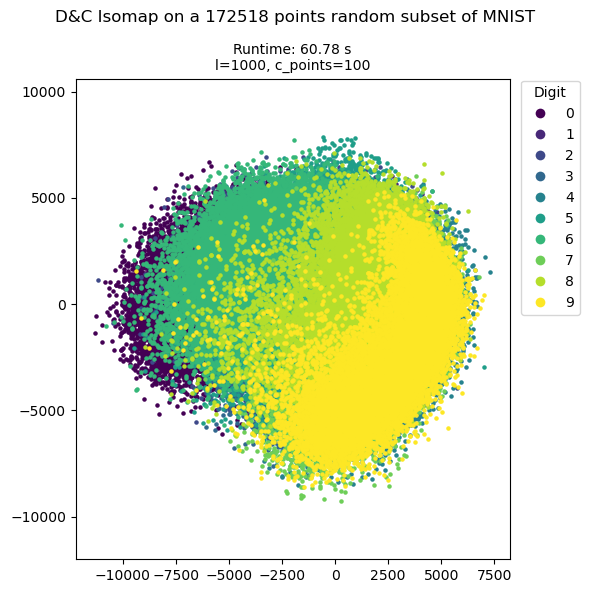

In [ ]:
# Plot the embedding
digits = np.unique(MNIST_target)
cmap = plt.get_cmap('viridis', len(digits))
# Create custom legend handles with larger markers
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                  for i, digit in enumerate(digits)]

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
for i, digit in enumerate(digits):
    mask = MNIST_target1 == digit
    ax1.scatter(MNIST_dc_full1[mask, 0], MNIST_dc_full1[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax1.set_title(
    f'Runtime: {time_MNIST_dc_full1:.2f} s\nl={l}, c_points={c_points}', fontsize=10)
ax1.axis('equal')
ax1.legend(handles=legend_handles, title="Digit",
           bbox_to_anchor=(1.01, 1.01), loc='upper left')

fig.suptitle(
    f'D&C Isomap on a {MNIST_target1.shape[0]} points random subset of MNIST')
plt.tight_layout()
plt.show()

As seen with a smaller subset of MNIST, the digits classification is very bad and the embedding reminds that obtained with SMACOF.

Isomap is very performant, so we will try to apply it directly to the whole partition 1.

In [ ]:
MNIST_bare2, time_MNIST_bare2 = benchmark(isomap,
                                          MNIST_pixels1, r=2, verbose=2)

: 

Given the limited RAM of the system, the Kernel has crashed while executing Isomap on the whole partition 1. Let us try with smaller subpartitions.

In [ ]:
n = 50000
sampled_indices = np.random.choice(
    n_images, size=n, replace=False)
sampled_pixels2 = MNIST_pixels[sampled_indices, :]
sampled_target2 = MNIST_target[sampled_indices]

print("Sampled MNIST_pixels1 shape:", sampled_pixels2.shape)
print("Sampled MNIST_target1 shape:", sampled_target2.shape)

Sampled MNIST_pixels1 shape: (50000, 784)
Sampled MNIST_target1 shape: (50000,)


In [ ]:
MNIST_bare2, time_MNIST_bare2 = benchmark(isomap,
                                          sampled_pixels2, r=2, verbose=2)

: 

With 50000 points, the Kernel has crashed as well.

In [ ]:
n = 10000
sampled_indices = np.random.choice(
    n_images, size=n, replace=False)
sampled_pixels2 = MNIST_pixels[sampled_indices, :]
sampled_target2 = MNIST_target[sampled_indices]

print("Sampled MNIST_pixels1 shape:", sampled_pixels2.shape)
print("Sampled MNIST_target1 shape:", sampled_target2.shape)

Sampled MNIST_pixels1 shape: (10000, 784)
Sampled MNIST_target1 shape: (10000,)


In [ ]:
MNIST_bare2, time_MNIST_bare2 = benchmark(isomap,
                                          sampled_pixels2, r=2, verbose=2)

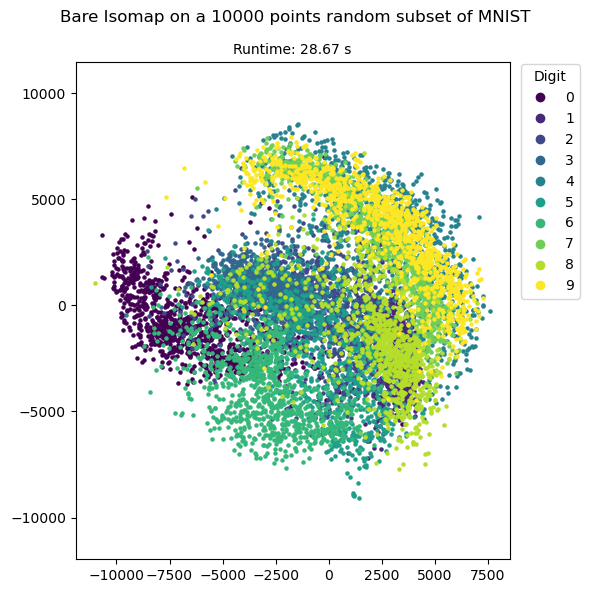

In [ ]:
# Plot the embedding
digits = np.unique(MNIST_target)
cmap = plt.get_cmap('viridis', len(digits))
# Create custom legend handles with larger markers
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                markersize=7,
                                markerfacecolor=cmap(i),
                                markeredgewidth=0,
                                label=int(digit))
                  for i, digit in enumerate(digits)]

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
for i, digit in enumerate(digits):
    mask = sampled_target2 == digit
    ax1.scatter(MNIST_bare2[mask, 0], MNIST_bare2[mask, 1],
                color=cmap(i),
                label=int(digit),
                s=5)
ax1.set_title(
    f'Runtime: {time_MNIST_bare2:.2f} s', fontsize=10)
ax1.axis('equal')
ax1.legend(handles=legend_handles, title="Digit",
           bbox_to_anchor=(1.01, 1.01), loc='upper left')

fig.suptitle(
    f'Bare Isomap on a {n} points random subset of MNIST')
plt.tight_layout()
plt.show()

## 2.2 From the 25th of April

In [3]:
# Load data and embeddings
with open(os.path.join(project_root, 'd_and_c', 'MNIST_5000.pkl'), "rb") as f:
    bare_data = pickle.load(f)
    sampled_pixels1 = bare_data["pixels"]
    sampled_target1 = bare_data["target"]

with open(os.path.join(pickle_path, "MNIST_5000_Isomap.pkl"), "rb") as f:
    bare_data = pickle.load(f)
    MNIST_bare1 = bare_data["embedding"]
    time_MNIST_bare1 = bare_data["runtime"]

with open(os.path.join(pickle_path, "MNIST_5000_DC_Isomap.pkl"), "rb") as f:
    dc_data = pickle.load(f)
    MNIST_dc1 = dc_data["embedding"]
    time_MNIST_dc1 = dc_data["runtime"]

Compute Pearson correlation between embeddings' dimensions of each digit.

In [4]:
digits = np.unique(sampled_target1)
correlations = {"Digit": [], "Corr_dim1": [], "Corr_dim2": []}

for digit in digits:
    mask = sampled_target1 == digit
    bare = MNIST_bare1[mask]
    dc = MNIST_dc1[mask]
    corr_dim0 = pearsonr(bare[:, 0], dc[:, 0])[0]
    corr_dim1 = pearsonr(bare[:, 1], dc[:, 1])[0]
    correlations["Digit"].append(int(digit))
    correlations["Corr_dim1"].append(corr_dim0)
    correlations["Corr_dim2"].append(corr_dim1)

df_corr = pd.DataFrame(correlations)
display(df_corr)

Digit  Corr_dim1  Corr_dim2
0      0   0.769584  -0.538422
1      1   0.432563  -0.696318
2      2   0.773259  -0.600132
3      3   0.664366  -0.419088
4      4   0.771355  -0.887588
5      5   0.701130  -0.785777
6      6   0.789199  -0.730109
7      7   0.805115  -0.945081
8      8   0.793234  -0.806569
9      9   0.860990  -0.925445

In [5]:
# Total correlation
print(f'Total correlation of dim1: {pearsonr(MNIST_bare1[:, 0], MNIST_dc1[:, 0])[0]}')
print(f'Total correlation of dim2: {pearsonr(MNIST_bare1[:, 1], MNIST_dc1[:, 1])[0]}')

Total correlation of dim1: 0.9195527127381181
Total correlation of dim2: -0.8623571714329816


Estimate bivariate densities of each digit for both embeddings after applying a Procrustes transformation.

In [6]:
# Apply procrustes
c_points = 100
sampled_idx = np.random.choice(MNIST_bare1.shape[0], size=c_points, replace=False)
target = MNIST_bare1[sampled_idx, :]
MNIST_dc1_procrustes = perform_procrustes(MNIST_dc1[:c_points, :], target, MNIST_dc1)

In [13]:
# Estimate densities
digits = np.unique(sampled_target1)
densities = {}

for method_name, embedding in [("Bare Isomap", MNIST_bare1), ("D&C Isomap", MNIST_dc1_procrustes)]:
    densities[method_name] = {}
    for digit in digits:
        mask = sampled_target1 == digit
        data = embedding[mask].T
        kde = gaussian_kde(data)
        densities[method_name][int(digit)] = kde

In [14]:
n = 5000

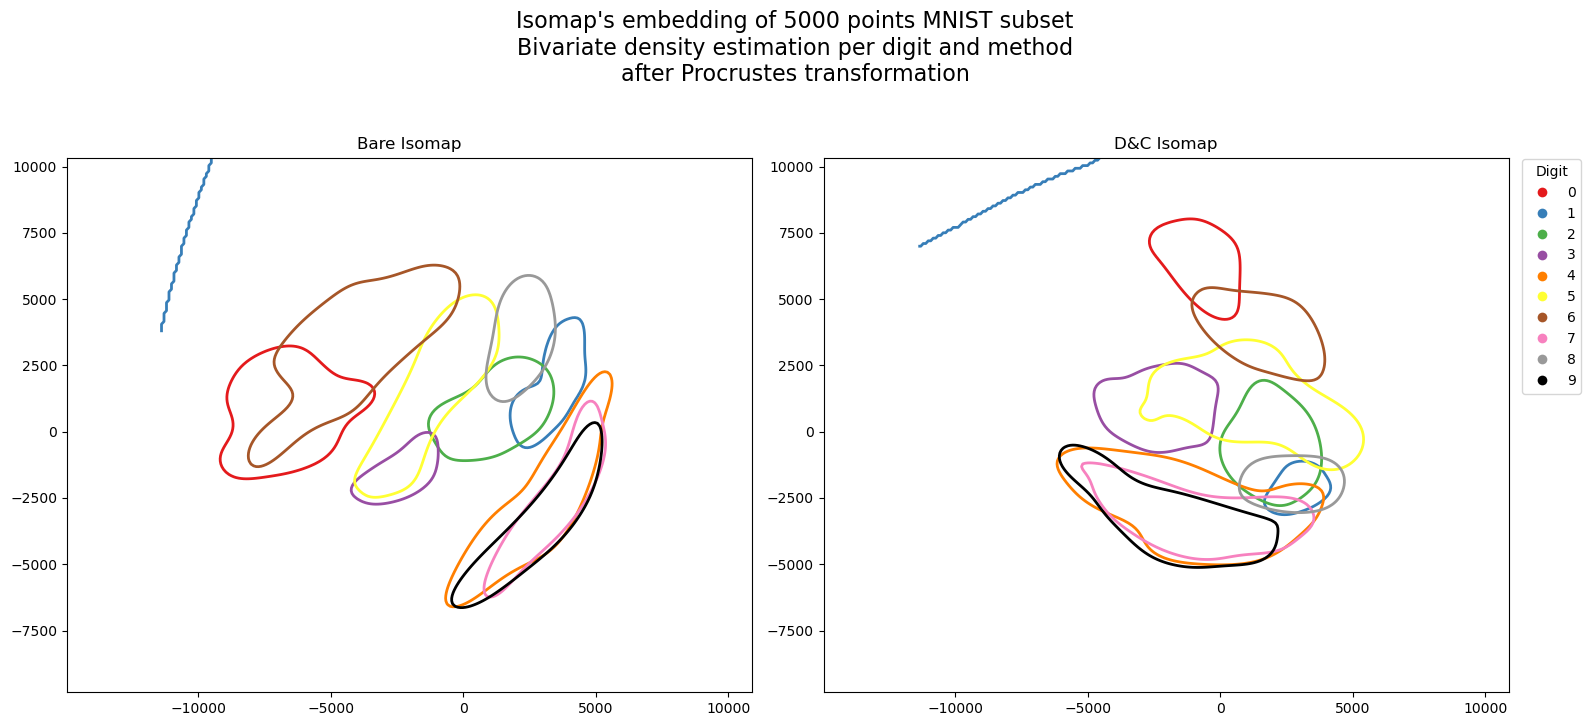

In [18]:
# Contour plot estimated densities
set1_colors = list(plt.get_cmap('Set1').colors)
set1_colors.append((0, 0, 0))  # Add black if needed
cmap = mcolors.ListedColormap(set1_colors[:len(digits)])

method_names = ["Bare Isomap", "D&C Isomap"]
embeddings = [MNIST_bare1, MNIST_dc1_procrustes]

# Compute meshgrid for contours
all_x = np.concatenate([emb[:, 0] for emb in embeddings])
all_y = np.concatenate([emb[:, 1] for emb in embeddings])
xpad = (all_x.max() - all_x.min()) * 0.05
ypad = (all_y.max() - all_y.min()) * 0.05
xmin, xmax = all_x.min() - xpad, all_x.max() + xpad
ymin, ymax = all_y.min() - ypad, all_y.max() + ypad
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200),
    np.linspace(ymin, ymax, 200)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
for col, method in enumerate(method_names):
    ax = axes[col]
    for i, digit in enumerate(digits):
        kde = densities[method][int(digit)]
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels=1, colors=[cmap(i)], linewidths=2)
    ax.set_title(f"{method}")
    ax.axis('equal')
    if col == 1:
        # Custom legend on the right plot
        legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o',
                                        markersize=7,
                                        markerfacecolor=cmap(i),
                                        markeredgewidth=0,
                                        label=int(digit))
                          for i, digit in enumerate(digits)]
        ax.legend(handles=legend_handles, title="Digit",
                  bbox_to_anchor=(1.01, 1.01), loc='upper left')
fig.suptitle(
    f"Isomap's embedding of {n} points MNIST subset\nBivariate density estimation per digit and method\nafter Procrustes transformation", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

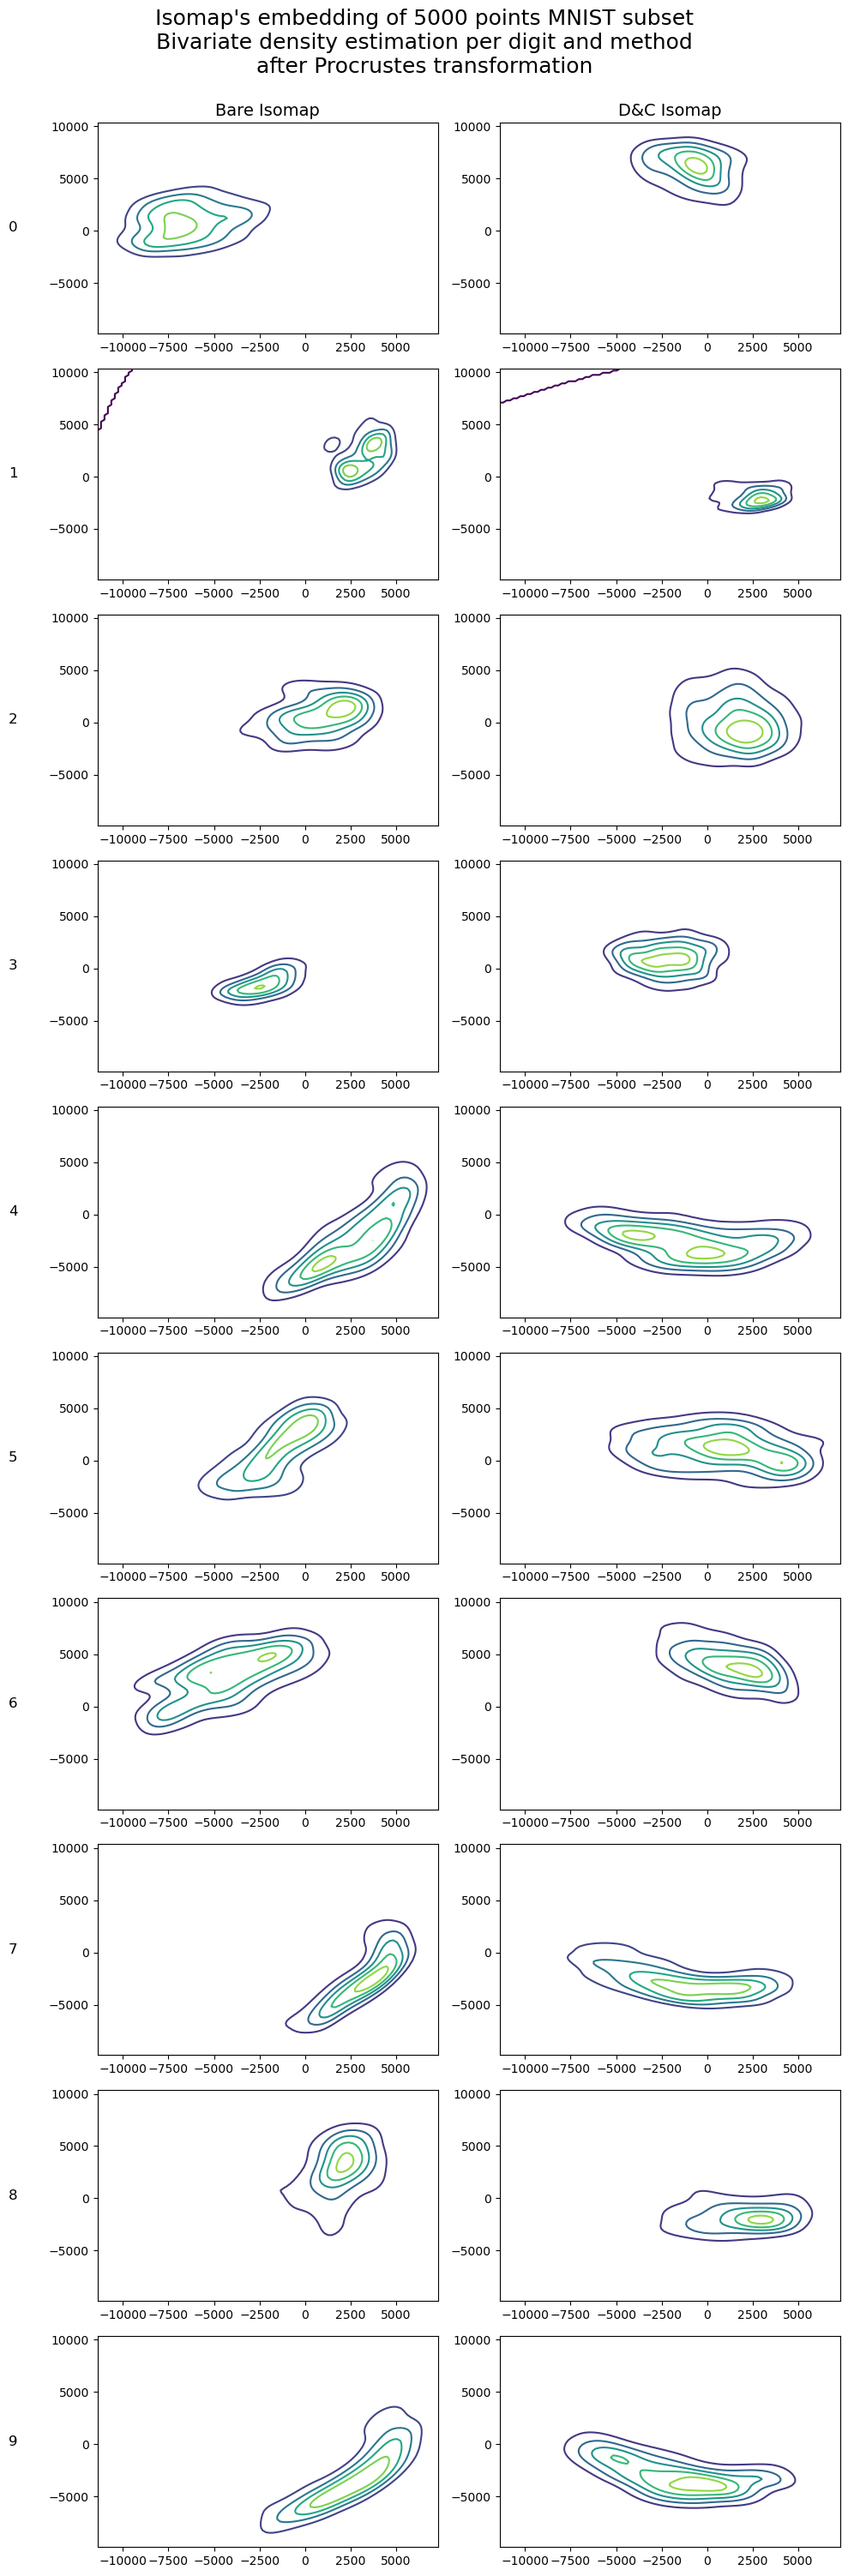

In [17]:
# Compare each digit with more contour lines
digits = np.unique(sampled_target1)
method_names = ["Bare Isomap", "D&C Isomap"]

# Compute meshgrid across all digits and methods
all_x = np.concatenate([MNIST_bare1[:, 0], MNIST_dc1_procrustes[:, 0]])
all_y = np.concatenate([MNIST_bare1[:, 1], MNIST_dc1_procrustes[:, 1]])
xpad = (all_x.max() - all_x.min()) * 0.05
ypad = (all_y.max() - all_y.min()) * 0.05
xmin, xmax = all_x.min() - xpad, all_x.max() + xpad
ymin, ymax = all_y.min() - ypad, all_y.max() + ypad

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 100),
    np.linspace(ymin, ymax, 100)
)

# Create plot grid
fig, axes = plt.subplots(len(digits), len(method_names), figsize=(
    10, 30), sharex=False, sharey=False)
for row, digit in enumerate(digits):
    for col, method in enumerate(method_names):
        ax = axes[row, col]
        kde = densities[method][int(digit)]
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels=5, cmap='viridis')
        if col == 0:
            ax.set_ylabel(f"{int(digit)}", fontsize=12,
                          rotation=0, labelpad=30, va='center')
        if row == 0:
            ax.set_title(method_names[col], fontsize=14)
fig.suptitle(f"Isomap's embedding of {n} points MNIST subset\nBivariate density estimation per digit and method\nafter Procrustes transformation",
             fontsize=18, y=1)
plt.tight_layout()
plt.show()